In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


# Automatic differentiation with pytorch

$$y = f(x) = 5x^2 + 1$$
$$\frac{\partial y}{\partial x} = 10x$$
$$\frac{\partial y}{\partial x}\Big|_{x=1} = 10$$


In [2]:
x = torch.tensor(1.0, requires_grad=True)

In [3]:
y = 5 * x ** 2 + 1

In [4]:
print("Before calling `backward`, x.grad: ", x.grad)

Before calling `backward`, x.grad:  None


In [5]:
y.backward()

In [6]:
print("After calling `backward`, x.grad: ", x.grad)


After calling `backward`, x.grad:  tensor(10.)


Another example

$$y = f(x1, x2) = 5 * x_1 ^ 2 + x_2 + 1$$

$$\frac{\partial y}{\partial x_1} = 10x_1$$
$$\frac{\partial y}{\partial x_2} = 1$$

$$\frac{\partial y}{\partial x_1}\Big|_{x_1=1, x_2=10} = 10$$
$$\frac{\partial y}{\partial x_2}\Big|_{x_1=1, x_2=10} = 1$$


In [7]:
# y = 5*x**2 + 1

x1 = torch.tensor(1.0, requires_grad=True)
x2 = torch.tensor(10.0, requires_grad=True)

In [8]:
y = 5 * x1**2 + 1 + x2

In [9]:
print("Before calling `backward`, (x1.grad, x2.grad): ", (x1.grad, x2.grad))

Before calling `backward`, (x1.grad, x2.grad):  (None, None)


In [10]:
y.backward()

In [11]:
print("After calling `backward`, (x1.grad, x2.grad): ", (x1.grad, x2.grad))

After calling `backward`, (x1.grad, x2.grad):  (tensor(10.), tensor(1.))


# Working with synthetic data

## Data

In [12]:
df = pd.read_csv("data.csv")

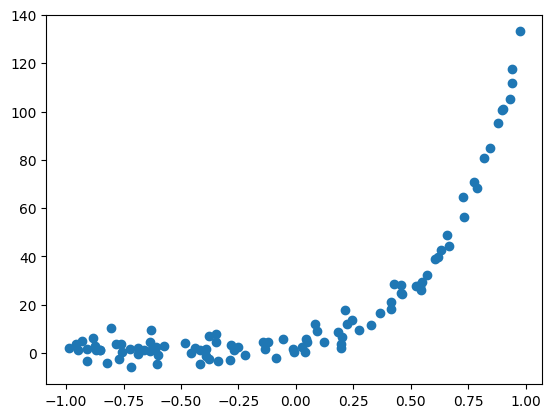

In [13]:
plt.scatter(df["x"], df["y"])

# Model

In [14]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

X = torch.tensor(df["x"])[:, None].float()
Y = torch.tensor(df["y"])[:, None].float()


model = lambda x: a + b * x
weights = [a, b]

# Loss function

In [15]:
loss_fn = lambda y_pred, y_gt: ((y_pred - y_gt) ** 2).mean()

# Optimizer

In [16]:
optimizer = torch.optim.SGD(weights, lr=1e-2)

In [17]:
def train_one_epoch(model, optimizer, X, Y, BS=100):
    indexes = np.random.permutation(len(X))
    losses = []
    a_values = []
    b_values = []
    for i, batch_start in enumerate(range(0, len(X), BS)):
        optimizer.zero_grad()
        
        x = X[indexes[batch_start:batch_start+BS]]
        y = Y[indexes[batch_start:batch_start+BS]]

        y_preds = model(x)

        loss = loss_fn(y_preds, y)
        loss.backward()

        optimizer.step()
        
        losses.append(loss.item())
        a_values.append(a.item())
        b_values.append(b.item())
        # print(f"step={i}, loss={loss.item():0.03f}, ws={[round(x.item(), 2) for x in weights]}")
    return losses, a_values, b_values

loss=386.797, a=21.939, b=40.924: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5130.99it/s]


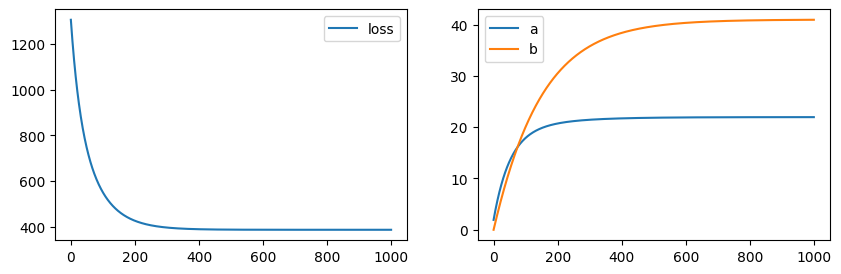

In [18]:
losses = []
a_values = []
b_values = []

pbar = tqdm(range(1000))

for ep in pbar:
    epoch_loss, epoch_a, epoch_b = train_one_epoch(model, optimizer, X, Y)
    losses.extend(epoch_loss)
    a_values.extend(epoch_a)
    b_values.extend(epoch_b)
    if (ep + 1) % 100 == 0:
        pbar.set_description(f"loss={losses[-1]:0.03f}, a={a_values[-1]:0.03f}, b={b_values[-1]:0.03f}")
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(losses, label="loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(a_values, label="a")
plt.plot(b_values, label="b")
plt.legend()


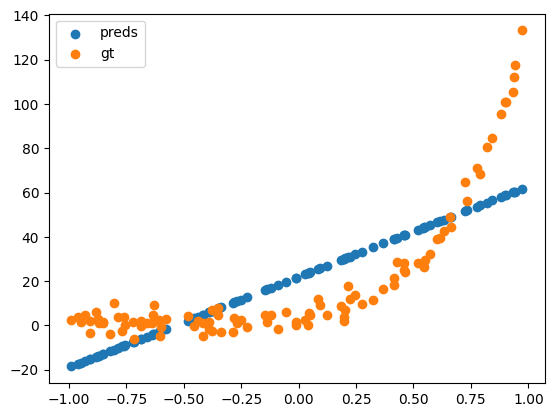

In [19]:
with torch.no_grad():
    y_preds = model(X)
    plt.scatter(X, y_preds, label="preds")
    plt.scatter(X, Y, label="gt")

plt.legend()

In [20]:
class Model(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_act="relu", n_layers=3, hidden_dim=128):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                nn.Linear(input_shape if i == 0 else hidden_dim, hidden_dim)
                for i in range(n_layers)
            ]
        )
        if hidden_act == "relu":
            self.hidden_act = nn.functional.relu
        else:
            raise ValueError

        self.output_layer = nn.Linear(hidden_dim, output_shape)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.hidden_act(x)
        output = self.output_layer(x)
        return output
        

In [21]:
model = Model(input_shape=1, output_shape=1)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss=39.170: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1123.24it/s]


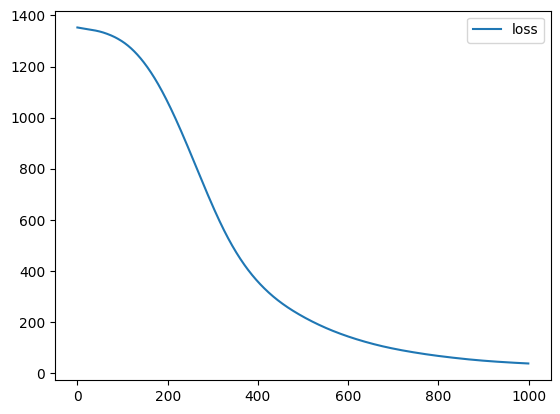

In [23]:
losses = []
a_values = []
b_values = []

pbar = tqdm(range(1000))
for ep in pbar:
    epoch_loss, epoch_a, epoch_b = train_one_epoch(model, optimizer, X[:, None], Y[:, None])
    losses.extend(epoch_loss)
    a_values.extend(epoch_a)
    b_values.extend(epoch_b)
    if (ep + 1) % 100 == 0:
        pbar.set_description(f"loss={losses[-1]:0.03f}")
plt.plot(losses, label="loss")
plt.legend()


# Exercise

You are tasked with training the following models on the given dataset.

1. $y = a + b * x $
2. $y = a + b * x + c * x^2$
3. $y = a e^{bx}$
4. a MLP. If you decide to use the `Model` class above, you must change one or more of the number of layers, the number of neurons or the activation function.

## Deliverables
* A plot with the learning curves depicting 1k epochs for each model.
* A single plot containing the predictions of the trained models and the ground truth data.
* A brief write-up explaining how the choice of the model (hypothesis function) influences the final outcome, along with suggestions for improving the results.